# <font color=orange>**Evrisimsel Sinir Aglari ile Nesne Tespiti**</font> <font color=gray>**(CNN)**</font>

## <font color=orange>**Bolge Onerisi Nesne Tespiti**</font> <font color=gray>**-**</font>

In [2]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import matplotlib.pyplot as plt 
import numpy as np
import cv2

from non_max_suppression import non_max_suppression

In [3]:
def selective_search(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    ss.switchToSelectiveSearchQuality()
    
    rects = ss.process()
    return rects[:1000]

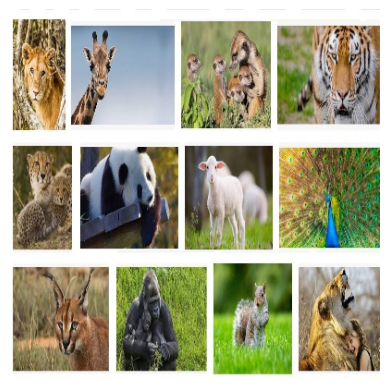

In [5]:
# Model

model = ResNet50(weights='imagenet')
image = cv2.imread('animals.jpg')
image = cv2.resize(image, dsize=(400,400))
(H, W) = image.shape[:2]

im = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(im),plt.axis('off');

In [6]:
# ss

rects = selective_search(image)

proposal = []
boxes = []
for (x, y, w, h) in rects:
    
    if (w / float(W) < 0.1) or (h / float(H) < 0.1):
        continue
        
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi,(224,224))
    
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    
    proposal.append(roi)
    boxes.append((x,y,w,h))

In [7]:
proposal = np.array(proposal)

preds = model.predict(proposal)
preds = imagenet_utils.decode_predictions(preds, top = 1)

10/10 [==============================] - 27s 3s/step


In [8]:
# Cikan sonuclari yorumlayacak hale getirdik.

In [9]:
labels = {}
min_conf = 0.8

for (i, p) in enumerate(preds):
    
    (_,label,prob) = p[0]
    if prob >= min_conf:
        (x, y, w, h) = boxes[i]
        box = (x, y, x+w, y+h)
        L = labels.get(label, [])
        L.append((box,prob))
        labels[label] = L

In [18]:
clone = image.copy()

for label in labels.keys():
    for (box, prob) in labels[label]:
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)
        
        for (startX, startY, endX, endY) in boxes:
            cv2.rectangle(clone, (startX,startY), (endX,endY),(0,0,255), 1)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, label, (startX,y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255),2)
            
            cv2.imshow('After',clone)
            if cv2.waitKey(1) & 0xFF == ord('q'): break